<a href="https://colab.research.google.com/github/KoNGoL/tfm_breast_cancer_detection/blob/main/Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pydicom
%pip install opencv-python
%pip install pillow # optional 
%pip install pandas 
%pip install pypng 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#imports
import matplotlib.pyplot as plt
import pydicom as dicom
import os
# from google.colab.patches import cv2_imshow as cv2
import cv2 as cv2
import PIL # optional
import numpy as np
import png
from skimage import util


In [3]:
#initialize variables
in_path = "/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/"
out_path = "/home/fundamentia/python/tfm_breast_cancer_detection/pruebas/procesadas/"
name = "1-1.dcm"
out_name = name + ".png"

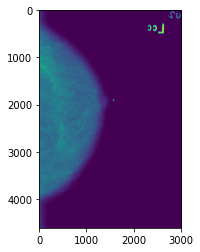

In [3]:
#convertir diccom a png
def convert_diccom_to_png(in_file, out_path):
  ds = dicom.dcmread(os.path.join(in_path, name))
  pixel_array_numpy = ds.pixel_array
  cv2.imwrite(os.path.join(out_path), pixel_array_numpy)

# image_path = in_path + "man2_mask2.dcm"
def show_diccom_img(diccom_path):
  ds = dicom.dcmread(diccom_path)
  plt.imshow(ds.pixel_array)
  plt.show()

def convert_diccom_to_png2(in_file, out_path):
  mri_file = open(in_file, 'rb')
  png_file = open(out_path, 'wb')
  # Extracting data from the mri file
  plan = dicom.read_file(mri_file)
  shape = plan.pixel_array.shape

  image_2d = []
  max_val = 0
  for row in plan.pixel_array:
      pixels = []
      for col in row:
          pixels.append(col)
          if col > max_val: max_val = col
      image_2d.append(pixels)

  # Rescaling grey scale between 0-255
  image_2d_scaled = []
  for row in image_2d:
      row_scaled = []
      for col in row:
          col_scaled = int((float(col) / float(max_val)) * 255.0)
          row_scaled.append(col_scaled)
      image_2d_scaled.append(row_scaled)

  # Writing the PNG file
  w = png.Writer(shape[1], shape[0], greyscale=True)
  w.write(png_file, image_2d_scaled)

convert_diccom_to_png(in_path + name, out_path + out_name)
show_diccom_img(in_path + name)

(4616, 3016, 3)
48 4568 30 2986


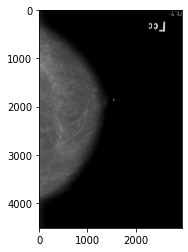

In [7]:
# recortar imagen
image_path = out_path + name + ".png"
def crop_img(image_path, output_path, x = 1, y = 4):
    img = cv2.imread(image_path)
    print(img.shape)
    # calculamos el % que se desea borrar
    y_start = int(img.shape[0]/(100-y))
    y_end = img.shape[0] - y_start
    x_start = int(img.shape[1]/(100-x))
    x_end = img.shape[1] - x_start
    print(y_start, y_end, x_start, x_end)
    # recortamos la imagen
    crop_img = img[y_start:y_end, x_start:x_end]
    plt.imshow(crop_img)
    cv2.imwrite(os.path.join(output_path), crop_img)

out_crop_path = out_path + name + "_recortdada.png"
crop_img(image_path, out_crop_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


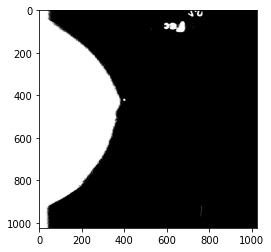

In [8]:
# reescalar imagen con black  background a 1024x1024
def rescale_img(image_path, output_path):
    # creamos una imagen negra de 1024x1024
    img_black = np.zeros((1024, 1024, 3))
    # leemos las dos imagenses y las reescalamos
    img_object = cv2.imread(image_path)
    img_object = cv2.resize(img_object, (768, 1024))
    # posicionamos la imagen en la parte izquierda de la imagen negra
    x = 0
    y = 0
    x_end = x + img_object.shape[0]
    y_end = y + img_object.shape[1]
    img_black[x:x_end,y:y_end] = img_object
    # guardamos la imagen
    plt.imshow(img_black)
    cv2.imwrite(os.path.join(output_path), img_black)

out_rescale_path = out_path + name + "_rescaled.png"
rescale_img(out_crop_path, out_rescale_path)

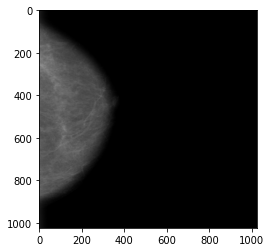

In [4]:
# eliminamos el ruido de la imagen (anotaciones de los medicos o manchas)
def remove_noise(image_path, output_path):
    img = cv2.imread(image_path)

    # normalizamos la imagen
    norm = util.img_as_ubyte((img - img.min()) / (img.max() - img.min()))
    gray = cv2.cvtColor(norm, cv2.COLOR_RGB2GRAY)

    # generamos los cortornos de la imagen
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # escogemos el area de mayor tamaño
    max_area = max(contours, key=cv2.contourArea)
    
    # generamos una mascara con el area de mayor tamaño
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [max_area], 0, (255, 255, 255), -1)

    # eliminamos el ruido de la imagen
    breast_img = cv2.bitwise_and(img, mask)
    
    # mostramos la imagen y la guardamos
    plt.imshow(breast_img)
    cv2.imwrite(os.path.join(output_path), breast_img)

input_image = out_path + name + "_rescaled.png"
output_noise_image = out_path + name + "_noise_removed.png"
remove_noise(input_image, output_noise_image)


In [ ]:
# CLAHE (contrast limited adaptive histogram equalization)
def clahe(image_path, output_path):
    img = cv2.imread(image_path)
    img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = img_clahe.apply(img)
    plt.imshow(img_clahe)
    cv2.imwrite(os.path.join(output_path), img_clahe)